# Bitcoin and Ethereum price prediction with RNN LSTM


# Full Code

In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import datetime
import numpy as np
import gc

# import the relevant Keras modules
#!pip install -q keras # this is not required if you are not using Google's colab
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

%matplotlib inline

Using TensorFlow backend.


In [0]:
neurons = 512                 # number of hidden units in the LSTM layer
activation_function = 'tanh'  # activation function for LSTM and Dense layer
loss = 'mse'                  # loss function for calculating the gradient, in this case Mean Squared Error
optimizer= 'adam'             # optimizer for appljying gradient decent
dropout = 0.25                # dropout ratio used after each LSTM layer to avoid overfitting
batch_size = 128              
epochs = 53                  
window_len = 7               # is an intiger to be used as the look back window for creating a single input sample.
training_size = 0.8           # porportion of data to be used for training
merge_date = '2016-01-01'     # the earliest date which we have data for both ETH and BTC or any other provided coin

In [0]:
def get_market_data(market, tag=True):
  """
  market: the full name of the cryptocurrency as spelled on coinmarketcap.com. eg.: 'bitcoin'
  tag: eg.: 'btc', if provided it will add a tag to the name of every column.
  returns: panda DataFrame
  This function will use the coinmarketcap.com url for provided coin/token page. 
  Reads the OHLCV and Market Cap.
  Converts the date format to be readable. 
  Makes sure that the data is consistant by converting non_numeric values to a number very close to 0.
  And finally tags each columns if provided.
  """
  market_data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 
                             "/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"), flavor='html5lib')[0]
  market_data = market_data.assign(Date=pd.to_datetime(market_data['Date']))  
  market_data['Volume'] = (pd.to_numeric(market_data['Volume'], errors='coerce').fillna(0))
  if tag:
    market_data.columns = [market_data.columns[0]] + [tag + '_' + i for i in market_data.columns[1:]]
  return market_data


def merge_data(a, b, from_date=merge_date):
  """
  a: first DataFrame
  b: second DataFrame
  from_date: includes the data from the provided date and drops the any data before that date.
  returns merged data as Pandas DataFrame
  """
  merged_data = pd.merge(a, b, on=['Date'])
  merged_data = merged_data[merged_data['Date'] >= from_date]
  return merged_data


def add_volatility(data, coins=['btc', 'eth']):
  """
  data: input data, pandas DataFrame
  coins: default is for 'btc and 'eth'. It could be changed as needed
  This function calculates the volatility and close_off_high of each given coin in 24 hours, 
  and adds the result as new columns to the DataFrame.
  Return: DataFrame with added columns
  """
  for coin in coins:
    # calculate the daily change
    kwargs = {coin + '_change': lambda x: (x[coin + '_Close'] - x[coin + '_Open']) / x[coin + '_Open'],
             coin + '_close_off_high': lambda x: 2*(x[coin + '_High'] - x[coin + '_Close']) / (x[coin + '_High'] - x[coin + '_Low']) - 1,
             coin + '_volatility': lambda x: (x[coin + '_High'] - x[coin + '_Low']) / (x[coin + '_Open'])}
    data = data.assign(**kwargs)
  return data


def create_model_data(data):
  """
  data: pandas DataFrame
  This function drops unnecessary columns and reverses the order of DataFrame based on decending dates.
  Return: pandas DataFrame
  """
  #data = data[['Date']+[coin+metric for coin in ['btc_', 'eth_'] for metric in ['Close','Volume','close_off_high','volatility']]]
  data = data[['Date']+[coin+metric for coin in ['btc_', 'eth_'] for metric in ['Close','Volume']]]
  data = data.sort_values(by='Date')
  return data


def split_data(data, training_size=0.8):
  """
  data: Pandas Dataframe
  training_size: proportion of the data to be used for training
  This function splits the data into training_set and test_set based on the given training_size
  Return: train_set and test_set as pandas DataFrame
  """
  return data[:int(training_size*len(data))], data[int(training_size*len(data)):]


def create_inputs(data, coins=['btc', 'eth'], window_len=window_len):
  """
  data: pandas DataFrame, this could be either training_set or test_set
  coins: coin datas which will be used as the input. Default is 'btc', 'eth'
  window_len: is an intiger to be used as the look back window for creating a single input sample.
  This function will create input array X from the given dataset and will normalize 'Close' and 'Volume' between 0 and 1
  Return: X, the input for our model as a python list which later needs to be converted to numpy array.
  """
  norm_cols = [coin + metric for coin in coins for metric in ['_Close', '_Volume']]
  inputs = []
  for i in range(len(data) - window_len):
    temp_set = data[i:(i + window_len)].copy()
    inputs.append(temp_set)
    for col in norm_cols:
      inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1  
  return inputs


def create_outputs(data, coin, window_len=window_len):
  """
  data: pandas DataFrame, this could be either training_set or test_set
  coin: the target coin in which we need to create the output labels for
  window_len: is an intiger to be used as the look back window for creating a single input sample.
  This function will create the labels array for our training and validation and normalize it between 0 and 1
  Return: Normalized numpy array for 'Close' prices of the given coin
  """
  return (data[coin + '_Close'][window_len:].values / data[coin + '_Close'][:-window_len].values) - 1


def to_array(data):
  """
  data: DataFrame
  This function will convert list of inputs to a numpy array
  Return: numpy array
  """
  x = [np.array(data[i]) for i in range (len(data))]
  return np.array(x)


def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  """
  inputs: input data as numpy array
  output_size: number of predictions per input sample
  neurons: number of neurons/ units in the LSTM layer
  active_func: Activation function to be used in LSTM layers and Dense layer
  dropout: dropout ration, default is 0.25
  loss: loss function for calculating the gradient
  optimizer: type of optimizer to backpropagate the gradient
  This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer 
  and finally a dense layer to produce the output using keras' sequential model.
  Return: Keras sequential model and model summary
  """
  model = Sequential()
  model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))
  model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
  model.summary()
  return model

In [0]:
def show_plot(data, tag):
  fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
  ax1.set_ylabel('Closing Price ($)',fontsize=12)
  ax2.set_ylabel('Volume ($ bn)',fontsize=12)
  ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
  ax2.set_yticklabels(range(10))
  ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax1.set_xticklabels('')
  ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
  ax1.plot(data['Date'].astype(datetime.datetime),data[tag +'_Open'])
  ax2.bar(data['Date'].astype(datetime.datetime).values, data[tag +'_Volume'].values)
  fig.tight_layout()
  plt.show()
  
def date_labels():
  last_date = market_data.iloc[0, 0]
  date_list = [last_date - datetime.timedelta(days=x) for x in range(len(X_test))]
  return[date.strftime('%m/%d/%Y') for date in date_list][::-1]

In [0]:
btc_data = get_market_data("bitcoin", tag='btc')
eth_data = get_market_data("ethereum", tag='eth')

In [6]:
btc_data.head()

,Date,btc_Open,btc_High,btc_Low,btc_Close,btc_Volume,btc_Market Cap
0,2018-03-09,9414.69,9466.35,8513.03,9337.55,8.704190e+09,159185000000
1,2018-03-08,9951.44,10147.40,9335.87,9395.01,7.186090e+09,168241000000
2,2018-03-07,10803.90,10929.50,9692.12,9965.57,8.797910e+09,182631000000
3,2018-03-06,11500.10,11500.10,10694.30,10779.90,6.832170e+09,194378000000
4,2018-03-05,11532.40,11704.10,11443.90,11573.30,6.468540e+09,194903000000


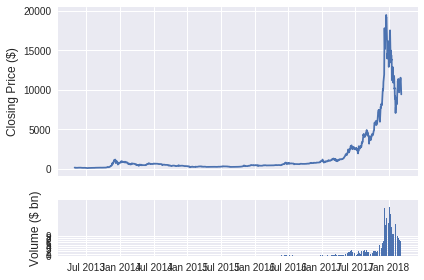

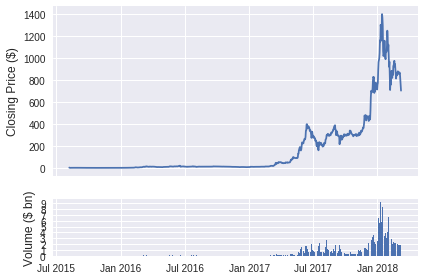

In [7]:
show_plot(btc_data, tag='btc')
show_plot(eth_data, tag='eth')

In [0]:
market_data = merge_data(btc_data, eth_data)
model_data = create_model_data(market_data)
train_set, test_set = split_data(model_data)

In [9]:
model_data.head()

,Date,btc_Close,btc_Volume,eth_Close,eth_Volume
798,2016-01-01,434.33,36278900.0,0.948024,206062
797,2016-01-02,433.44,30096600.0,0.937124,255504
796,2016-01-03,430.01,39633800.0,0.971905,407632
795,2016-01-04,433.09,38477500.0,0.954480,346245
794,2016-01-05,431.96,34522600.0,0.950176,219833


In [10]:
#@title Default title text
train_set = train_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

X_train = create_inputs(train_set)
Y_train_btc = create_outputs(train_set, coin='btc')
X_test = create_inputs(test_set)
Y_test_btc = create_outputs(test_set, coin='btc')

Y_train_eth = create_outputs(train_set, coin='eth')
Y_test_eth = create_outputs(test_set, coin='eth')

X_train, X_test = to_array(X_train), to_array(X_test)

date_list = date_labels()
print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_btc), np.shape(Y_test_btc))
print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_eth), np.shape(Y_test_eth))

(632, 7, 4) (153, 7, 4) (632,) (153,)
(632, 7, 4) (153, 7, 4) (632,) (153,)


In [11]:
len(Y_test_btc)

153

In [12]:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
btc_model = build_model(X_train, output_size=1, neurons=neurons)

# train model on data
btc_history = btc_model.fit(X_train, Y_train_btc, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_btc), shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 512)            1058816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 512)            2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
__________

632/632 [==============================] - 0s 635us/step - loss: 0.0042 - mean_absolute_error: 0.0463 - val_loss: 0.0153 - val_mean_absolute_error: 0.0968
Epoch 9/53
632/632 [==============================] - 0s 614us/step - loss: 0.0041 - mean_absolute_error: 0.0456 - val_loss: 0.0133 - val_mean_absolute_error: 0.0896
Epoch 10/53
632/632 [==============================] - 0s 614us/step - loss: 0.0037 - mean_absolute_error: 0.0432 - val_loss: 0.0130 - val_mean_absolute_error: 0.0894
Epoch 11/53
632/632 [==============================] - 0s 615us/step - loss: 0.0034 - mean_absolute_error: 0.0414 - val_loss: 0.0119 - val_mean_absolute_error: 0.0835
Epoch 12/53
632/632 [==============================] - 0s 615us/step - loss: 0.0034 - mean_absolute_error: 0.0420 - val_loss: 0.0116 - val_mean_absolute_error: 0.0835
Epoch 13/53
632/632 [==============================] - 0s 618us/step - loss: 0.0028 - mean_absolute_error: 0.0357 - val_loss: 0.0102 - val_mean_absolute_error: 0.0767
Epoch 14/53

632/632 [==============================] - 0s 611us/step - loss: 0.0018 - mean_absolute_error: 0.0284 - val_loss: 0.0069 - val_mean_absolute_error: 0.0607
Epoch 22/53
632/632 [==============================] - 0s 624us/step - loss: 0.0020 - mean_absolute_error: 0.0291 - val_loss: 0.0066 - val_mean_absolute_error: 0.0596
Epoch 23/53
632/632 [==============================] - 0s 613us/step - loss: 0.0017 - mean_absolute_error: 0.0280 - val_loss: 0.0065 - val_mean_absolute_error: 0.0588
Epoch 24/53
632/632 [==============================] - 0s 610us/step - loss: 0.0020 - mean_absolute_error: 0.0301 - val_loss: 0.0062 - val_mean_absolute_error: 0.0574
Epoch 25/53
632/632 [==============================] - 0s 614us/step - loss: 0.0018 - mean_absolute_error: 0.0288 - val_loss: 0.0061 - val_mean_absolute_error: 0.0569
Epoch 26/53
632/632 [==============================] - 0s 611us/step - loss: 0.0019 - mean_absolute_error: 0.0294 - val_loss: 0.0064 - val_mean_absolute_error: 0.0585
Epoch 27/5

Epoch 35/53
632/632 [==============================] - 0s 636us/step - loss: 0.0015 - mean_absolute_error: 0.0261 - val_loss: 0.0054 - val_mean_absolute_error: 0.0532
Epoch 36/53
632/632 [==============================] - 0s 614us/step - loss: 0.0015 - mean_absolute_error: 0.0259 - val_loss: 0.0049 - val_mean_absolute_error: 0.0512
Epoch 37/53
632/632 [==============================] - 0s 620us/step - loss: 0.0015 - mean_absolute_error: 0.0257 - val_loss: 0.0051 - val_mean_absolute_error: 0.0520
Epoch 38/53
632/632 [==============================] - 0s 616us/step - loss: 0.0017 - mean_absolute_error: 0.0277 - val_loss: 0.0050 - val_mean_absolute_error: 0.0508
Epoch 39/53
632/632 [==============================] - 0s 622us/step - loss: 0.0017 - mean_absolute_error: 0.0281 - val_loss: 0.0050 - val_mean_absolute_error: 0.0516
Epoch 40/53
632/632 [==============================] - 0s 616us/step - loss: 0.0016 - mean_absolute_error: 0.0269 - val_loss: 0.0051 - val_mean_absolute_error: 0.052

Epoch 49/53
632/632 [==============================] - 0s 620us/step - loss: 0.0014 - mean_absolute_error: 0.0251 - val_loss: 0.0049 - val_mean_absolute_error: 0.0510
Epoch 50/53
632/632 [==============================] - 0s 609us/step - loss: 0.0015 - mean_absolute_error: 0.0257 - val_loss: 0.0049 - val_mean_absolute_error: 0.0506
Epoch 51/53
632/632 [==============================] - 0s 613us/step - loss: 0.0015 - mean_absolute_error: 0.0259 - val_loss: 0.0049 - val_mean_absolute_error: 0.0511
Epoch 52/53
632/632 [==============================] - 0s 615us/step - loss: 0.0014 - mean_absolute_error: 0.0251 - val_loss: 0.0049 - val_mean_absolute_error: 0.0514
Epoch 53/53
632/632 [==============================] - 0s 600us/step - loss: 0.0016 - mean_absolute_error: 0.0265 - val_loss: 0.0048 - val_mean_absolute_error: 0.0504


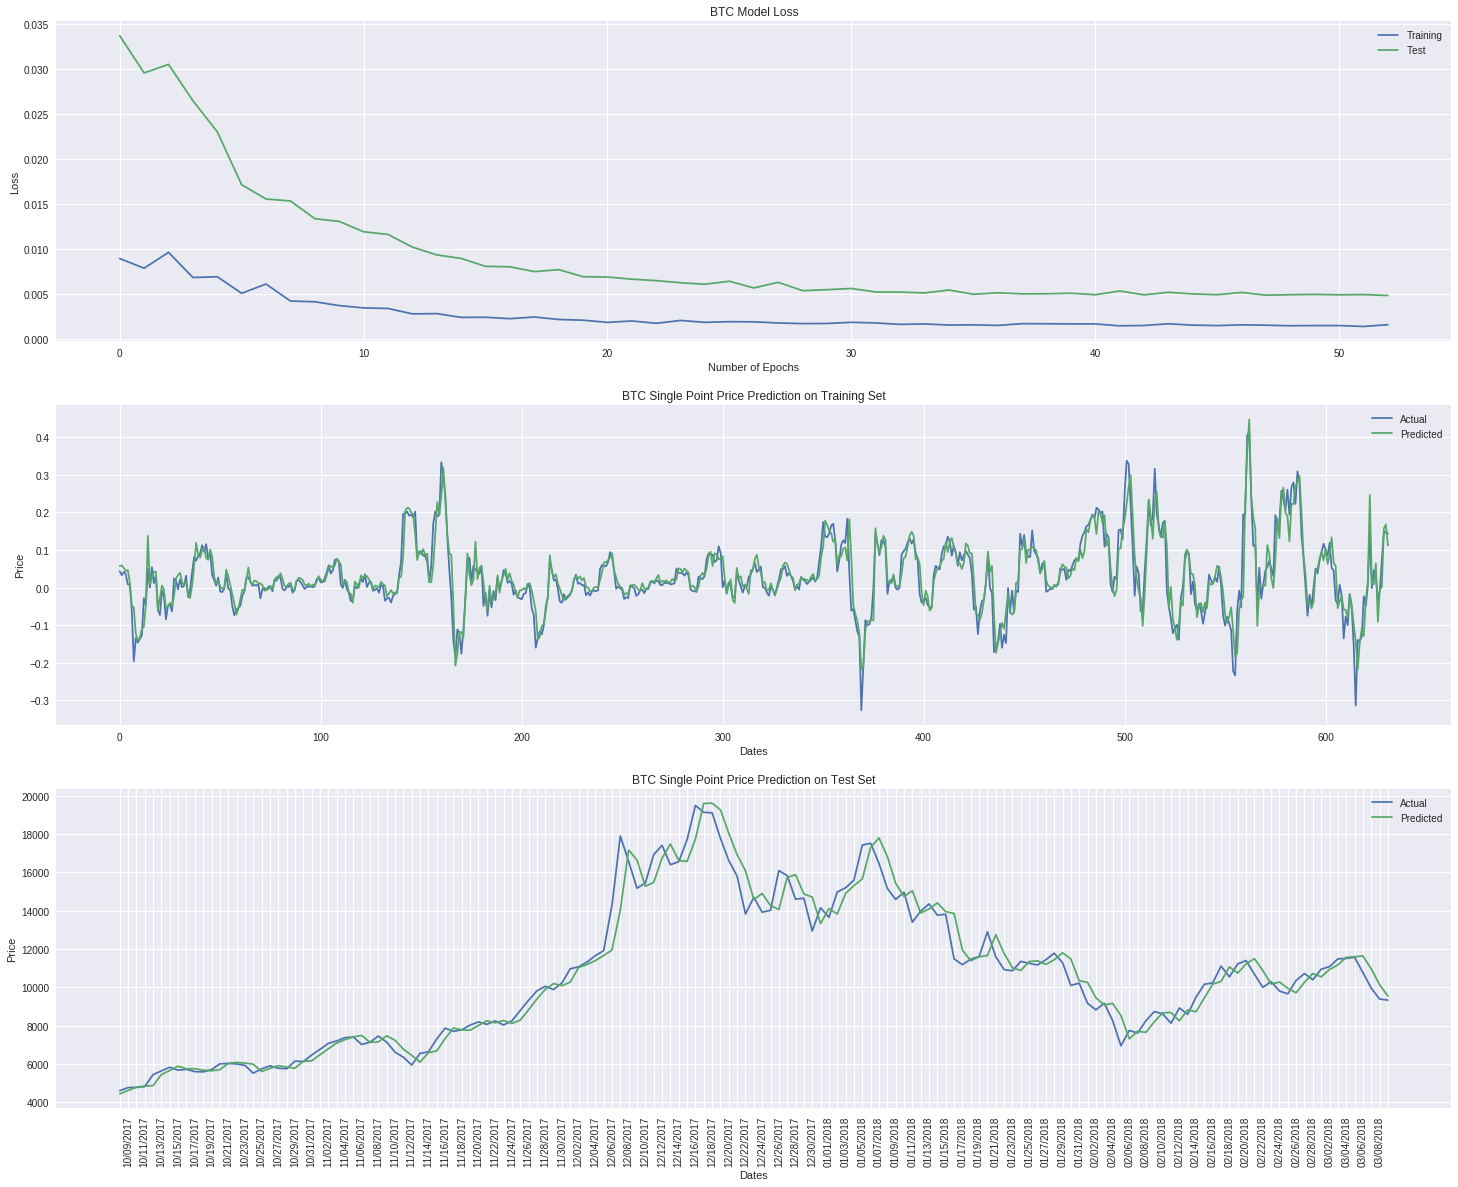

In [13]:
plt.figure(figsize=(25, 20))
plt.subplot(311)
plt.plot(btc_history.epoch, btc_history.history['loss'], )
plt.plot(btc_history.epoch, btc_history.history['val_loss'])
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('BTC Model Loss')
plt.legend(['Training', 'Test'])

plt.subplot(312)
plt.plot(Y_train_btc)
plt.plot(btc_model.predict(X_train))
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title('BTC Single Point Price Prediction on Training Set')
plt.legend(['Actual','Predicted'])

ax1 = plt.subplot(313)
plt.plot(test_set['btc_Close'][window_len:].values.tolist())
plt.plot(((np.transpose(btc_model.predict(X_test))+1) * test_set['btc_Close'].values[:-window_len])[0])
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title('BTC Single Point Price Prediction on Test Set')
plt.legend(['Actual','Predicted'])

ax1.set_xticks([x for x in range(len(date_list))])
for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
  label.set_visible(False)

plt.show()

In [14]:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
eth_model = build_model(X_train, output_size=1, neurons=neurons)

# train model on data
eth_history = eth_model.fit(X_train, Y_train_eth, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_eth), shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 7, 512)            1058816   
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 7, 512)            2099200   
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
__________

632/632 [==============================] - 0s 603us/step - loss: 0.0175 - mean_absolute_error: 0.0875 - val_loss: 0.0093 - val_mean_absolute_error: 0.0703
Epoch 9/53
632/632 [==============================] - 0s 625us/step - loss: 0.0170 - mean_absolute_error: 0.0867 - val_loss: 0.0088 - val_mean_absolute_error: 0.0669
Epoch 10/53
632/632 [==============================] - 0s 608us/step - loss: 0.0151 - mean_absolute_error: 0.0794 - val_loss: 0.0082 - val_mean_absolute_error: 0.0650
Epoch 11/53
632/632 [==============================] - 0s 622us/step - loss: 0.0154 - mean_absolute_error: 0.0798 - val_loss: 0.0078 - val_mean_absolute_error: 0.0631
Epoch 12/53
632/632 [==============================] - 0s 625us/step - loss: 0.0134 - mean_absolute_error: 0.0747 - val_loss: 0.0078 - val_mean_absolute_error: 0.0621
Epoch 13/53
632/632 [==============================] - 0s 613us/step - loss: 0.0122 - mean_absolute_error: 0.0728 - val_loss: 0.0070 - val_mean_absolute_error: 0.0593
Epoch 14/53

632/632 [==============================] - 0s 617us/step - loss: 0.0095 - mean_absolute_error: 0.0650 - val_loss: 0.0060 - val_mean_absolute_error: 0.0540
Epoch 22/53
632/632 [==============================] - 0s 612us/step - loss: 0.0094 - mean_absolute_error: 0.0646 - val_loss: 0.0054 - val_mean_absolute_error: 0.0515
Epoch 23/53
632/632 [==============================] - 0s 615us/step - loss: 0.0091 - mean_absolute_error: 0.0609 - val_loss: 0.0057 - val_mean_absolute_error: 0.0519
Epoch 24/53
632/632 [==============================] - 0s 617us/step - loss: 0.0089 - mean_absolute_error: 0.0622 - val_loss: 0.0053 - val_mean_absolute_error: 0.0500
Epoch 25/53
632/632 [==============================] - 0s 619us/step - loss: 0.0090 - mean_absolute_error: 0.0610 - val_loss: 0.0054 - val_mean_absolute_error: 0.0500
Epoch 26/53
632/632 [==============================] - 0s 617us/step - loss: 0.0089 - mean_absolute_error: 0.0610 - val_loss: 0.0056 - val_mean_absolute_error: 0.0512
Epoch 27/5

Epoch 35/53
632/632 [==============================] - 0s 609us/step - loss: 0.0103 - mean_absolute_error: 0.0660 - val_loss: 0.0050 - val_mean_absolute_error: 0.0498
Epoch 36/53
632/632 [==============================] - 0s 603us/step - loss: 0.0110 - mean_absolute_error: 0.0667 - val_loss: 0.0049 - val_mean_absolute_error: 0.0489
Epoch 37/53
632/632 [==============================] - 0s 612us/step - loss: 0.0095 - mean_absolute_error: 0.0642 - val_loss: 0.0056 - val_mean_absolute_error: 0.0520
Epoch 38/53
632/632 [==============================] - 0s 618us/step - loss: 0.0096 - mean_absolute_error: 0.0637 - val_loss: 0.0051 - val_mean_absolute_error: 0.0510
Epoch 39/53
632/632 [==============================] - 0s 621us/step - loss: 0.0096 - mean_absolute_error: 0.0653 - val_loss: 0.0054 - val_mean_absolute_error: 0.0503
Epoch 40/53
632/632 [==============================] - 0s 613us/step - loss: 0.0096 - mean_absolute_error: 0.0633 - val_loss: 0.0052 - val_mean_absolute_error: 0.051

Epoch 49/53
632/632 [==============================] - 0s 615us/step - loss: 0.0084 - mean_absolute_error: 0.0591 - val_loss: 0.0049 - val_mean_absolute_error: 0.0503
Epoch 50/53
632/632 [==============================] - 0s 622us/step - loss: 0.0081 - mean_absolute_error: 0.0578 - val_loss: 0.0049 - val_mean_absolute_error: 0.0493
Epoch 51/53
632/632 [==============================] - 0s 616us/step - loss: 0.0082 - mean_absolute_error: 0.0577 - val_loss: 0.0051 - val_mean_absolute_error: 0.0500
Epoch 52/53
632/632 [==============================] - 0s 611us/step - loss: 0.0080 - mean_absolute_error: 0.0575 - val_loss: 0.0049 - val_mean_absolute_error: 0.0493
Epoch 53/53
632/632 [==============================] - 0s 617us/step - loss: 0.0083 - mean_absolute_error: 0.0586 - val_loss: 0.0050 - val_mean_absolute_error: 0.0493


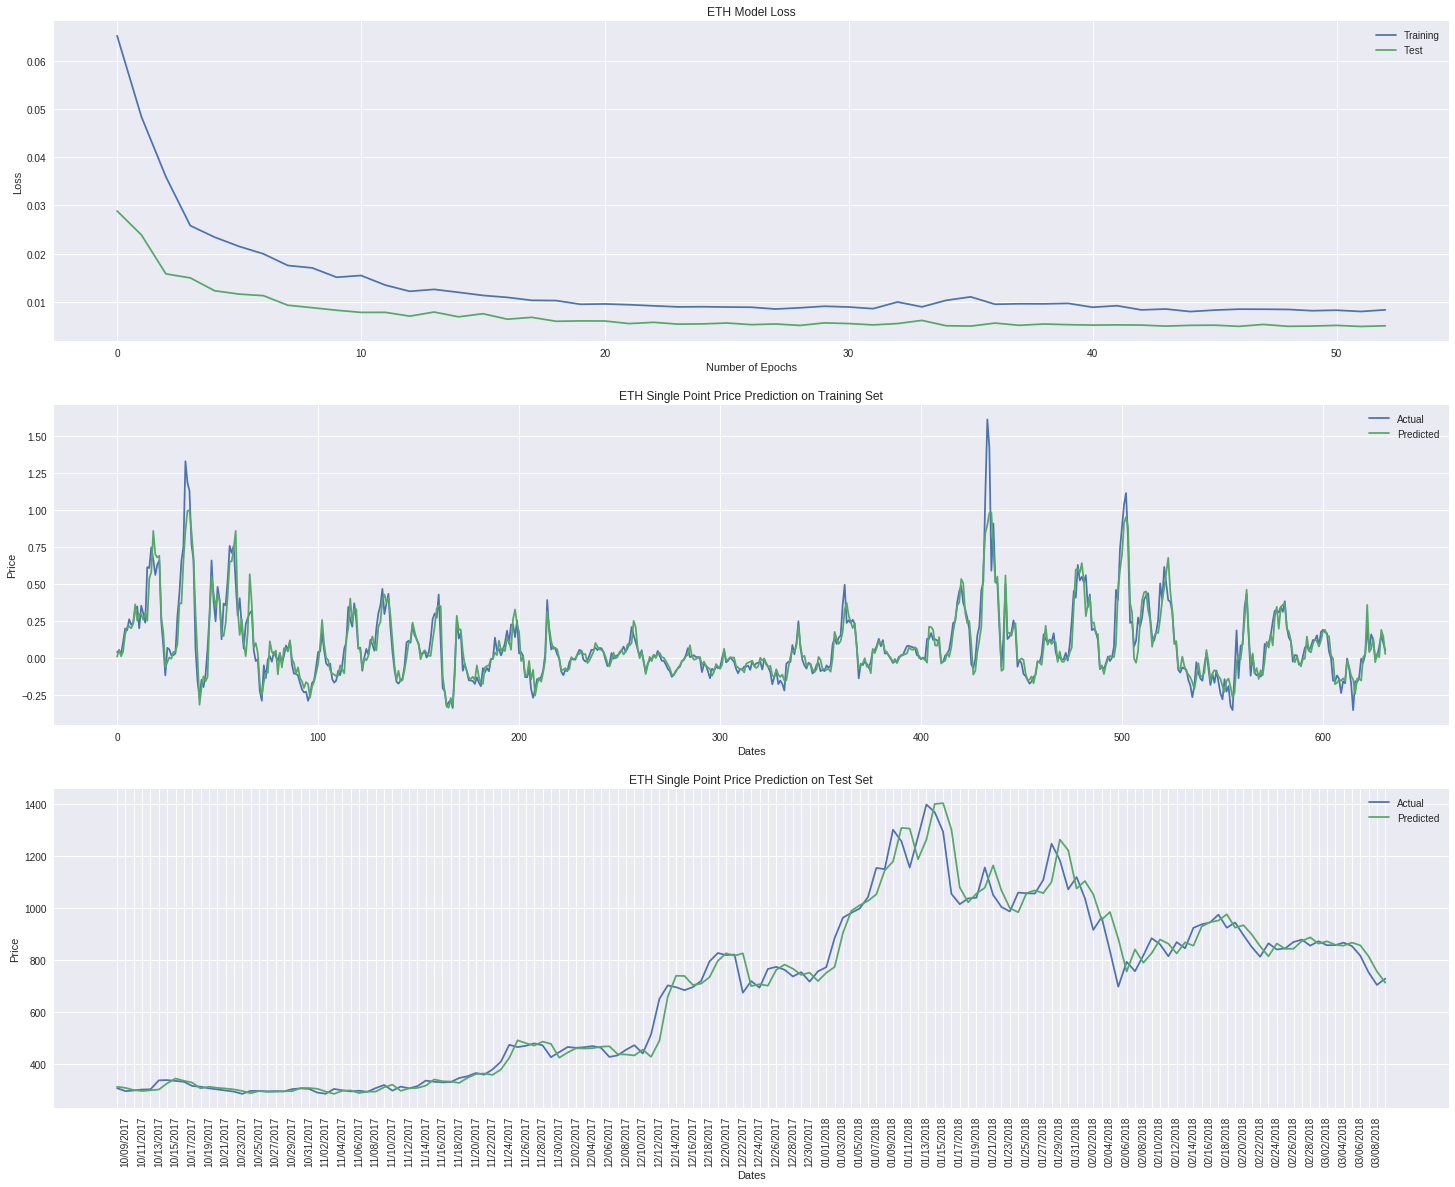

In [15]:
plt.figure(figsize=(25, 20))
plt.subplot(311)
plt.plot(eth_history.epoch, eth_history.history['loss'], )
plt.plot(eth_history.epoch, eth_history.history['val_loss'])
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('ETH Model Loss')
plt.legend(['Training', 'Test'])

plt.subplot(312)
plt.plot(Y_train_eth)
plt.plot(eth_model.predict(X_train))
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title('ETH Single Point Price Prediction on Training Set')
plt.legend(['Actual','Predicted'])

ax2 = plt.subplot(313)
plt.plot(test_set['eth_Close'][window_len:].values.tolist())
plt.plot(((np.transpose(eth_model.predict(X_test))+1) * test_set['eth_Close'].values[:-window_len])[0])
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title('ETH Single Point Price Prediction on Test Set')
plt.legend(['Actual','Predicted'])

ax2.set_xticks([x for x in range(len(date_list))])
for label in ax2.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
  label.set_visible(False)

plt.show()